In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime
import seaborn as sns
from imblearn.over_sampling import SMOTE


In [4]:
# Load the data
data = pd.read_csv('F:/fourth/NN project/data2 (1).csv')
data.head()


,Profession,Income,Credit_card_number,Expiry,Security_code,Fraud
0,DOCTOR,42509,3515418493460774,07/25,251,1
1,DOCTOR,80334,213134223583196,05/32,858,1
2,LAWYER,91552,4869615013764888,03/30,755,1
3,LAWYER,43623,341063356109385,01/29,160,1
4,DOCTOR,22962,4707418777543978402,11/30,102,0


In [5]:
# Convert Expiry to a Months_to_expiry (Numeric Feature)
current_date = datetime.now()
def calculate_months_to_expiry(expiry):
    exp_month, exp_year = map(int, expiry.split("/"))
    expiry_date = datetime(year=2000 + exp_year, month=exp_month, day=1)
    return max(0, (expiry_date.year - current_date.year) * 12 + (expiry_date.month - current_date.month))

data['Months_to_expiry'] = data['Expiry'].apply(calculate_months_to_expiry)

data.head()

,Profession,Income,Credit_card_number,Expiry,Security_code,Fraud,Months_to_expiry
0,DOCTOR,42509,3515418493460774,07/25,251,1,6
1,DOCTOR,80334,213134223583196,05/32,858,1,88
2,LAWYER,91552,4869615013764888,03/30,755,1,62
3,LAWYER,43623,341063356109385,01/29,160,1,48
4,DOCTOR,22962,4707418777543978402,11/30,102,0,70


In [6]:
# Convert Security_code to a Security_code_length (Numeric Feature)
data['Security_code'] = data['Security_code'].astype(str) #convert to string

lengths = []

for i in range(data.shape[0]):
    lengths.append(len(data['Security_code'].values[i]))  

data['Security_code_length'] = np.array(lengths)
data.head()

,Profession,Income,Credit_card_number,Expiry,Security_code,Fraud,Months_to_expiry,Security_code_length
0,DOCTOR,42509,3515418493460774,07/25,251,1,6,3
1,DOCTOR,80334,213134223583196,05/32,858,1,88,3
2,LAWYER,91552,4869615013764888,03/30,755,1,62,3
3,LAWYER,43623,341063356109385,01/29,160,1,48,3
4,DOCTOR,22962,4707418777543978402,11/30,102,0,70,3


In [7]:
# Encode categorical features if any
# for col in data.columns:
#     if data[col].dtype == 'object':
#         le = LabelEncoder()
#         data[col] = le.fit_transform(data[col])

# data.head()

In [8]:
data = data.drop(columns=['Credit_card_number', 'Expiry','Security_code' ])

In [9]:
# Prepare features and labels
X = data.drop(columns=['Fraud'])
y = data['Fraud']

X.head()

,Profession,Income,Months_to_expiry,Security_code_length
0,DOCTOR,42509,6,3
1,DOCTOR,80334,88,3
2,LAWYER,91552,62,3
3,LAWYER,43623,48,3
4,DOCTOR,22962,70,3


In [10]:
# Feature scaling
scaler = StandardScaler()
X[['Income']] = scaler.fit_transform(X[['Income']])  
# X[['Months_to_expiry']] = scaler.fit_transform(X[['Months_to_expiry']])  
# X[['Security_code_length']] = scaler.fit_transform(X[['Security_code_length']])  

X.head()

,Profession,Income,Months_to_expiry,Security_code_length
0,DOCTOR,-0.251496,6,3
1,DOCTOR,1.060219,88,3
2,LAWYER,1.449243,62,3
3,LAWYER,-0.212864,48,3
4,DOCTOR,-0.929357,70,3


In [11]:
# One-hot encode the 'Profession' column
profession_dummies = pd.get_dummies(data['Profession'], drop_first=False)
X = pd.concat([X, profession_dummies], axis=1)

X.head()

,Profession,Income,Months_to_expiry,Security_code_length,DOCTOR,ENGINEER,LAWYER
0,DOCTOR,-0.251496,6,3,True,False,False
1,DOCTOR,1.060219,88,3,True,False,False
2,LAWYER,1.449243,62,3,False,False,True
3,LAWYER,-0.212864,48,3,False,False,True
4,DOCTOR,-0.929357,70,3,True,False,False


In [12]:
X.drop(columns=['Profession'], inplace=True)
X.head()

,Income,Months_to_expiry,Security_code_length,DOCTOR,ENGINEER,LAWYER
0,-0.251496,6,3,True,False,False
1,1.060219,88,3,True,False,False
2,1.449243,62,3,False,False,True
3,-0.212864,48,3,False,False,True
4,-0.929357,70,3,True,False,False


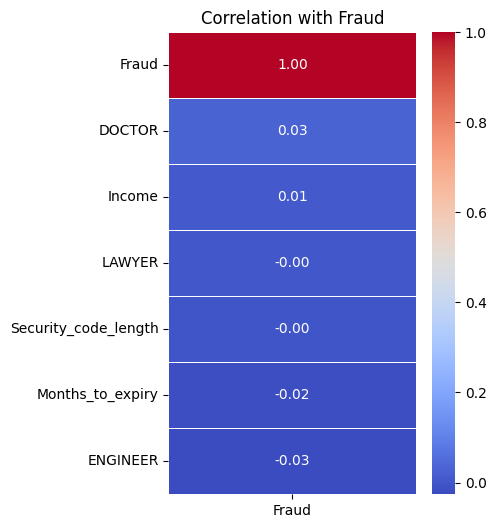

In [13]:
df = pd.concat([X, y], axis=1)

# Calculate the correlation matrix
corr_matrix = df.corr()

# Extract correlation values with respect to the target variable (Fraud)
target_variable = 'Fraud'
target_corr = corr_matrix[[target_variable]].sort_values(by=target_variable, ascending=False)

plt.figure(figsize=(4, 6))
sns.heatmap(target_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f'Correlation with {target_variable}')
plt.show()

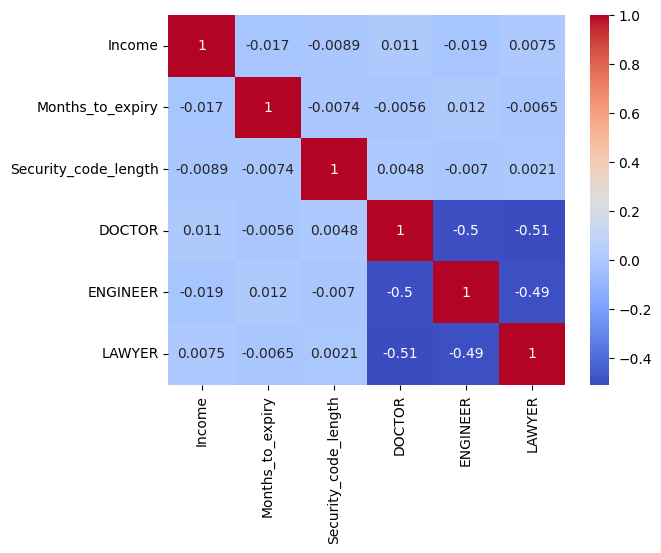

In [14]:
import seaborn as sns
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [15]:
# X.drop(columns=['Months_to_expiry'], inplace=True)
# X.drop(columns=['ENGINEER'], inplace=True)

In [16]:
# Ensure the data is in float32 format 
X = X.astype('float32')
y = y.astype('int32') #not important
print(X.dtypes)
df.head()

Income                  float32
Months_to_expiry        float32
Security_code_length    float32
DOCTOR                  float32
ENGINEER                float32
LAWYER                  float32
dtype: object


,Income,Months_to_expiry,Security_code_length,DOCTOR,ENGINEER,LAWYER,Fraud
0,-0.251496,6,3,True,False,False,1
1,1.060219,88,3,True,False,False,1
2,1.449243,62,3,False,False,True,1
3,-0.212864,48,3,False,False,True,1
4,-0.929357,70,3,True,False,False,0


In [17]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(y_train.value_counts())


(7000, 6)
(7000,)
Fraud
0    3508
1    3492
Name: count, dtype: int64


In [18]:
#  handling class imbalance
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print(y_train.value_counts())


Fraud
1    3508
0    3508
Name: count, dtype: int64


# model number one

In [19]:
# Build the neural network model
model1 = Sequential([
    Input(shape=(X_train.shape[1],)),  
    Dense(128, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid') 
])

In [20]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [21]:
# Compile the model
model1.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])


In [22]:
# Train the model
history = model1.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

Epoch 1/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4958 - loss: 1.1405 - val_accuracy: 0.4907 - val_loss: 0.6940
Epoch 2/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5125 - loss: 0.6929 - val_accuracy: 0.4907 - val_loss: 0.6938
Epoch 3/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5017 - loss: 0.6937 - val_accuracy: 0.5077 - val_loss: 0.6936
Epoch 4/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4947 - loss: 0.6934 - val_accuracy: 0.4890 - val_loss: 0.6936
Epoch 5/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4946 - loss: 0.6933 - val_accuracy: 0.4903 - val_loss: 0.6935
Epoch 6/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5020 - loss: 0.6931 - val_accuracy: 0.5073 - val_loss: 0.6934
Epoch 7/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5039 - loss: 0.6931 - val_accuracy: 0.4877 - val_loss: 0.6934
Epoch 8/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: 0.6930 - val_accu

In [23]:
# Evaluate the model
loss, accuracy = model1.evaluate(X_test, y_test, verbose=0)

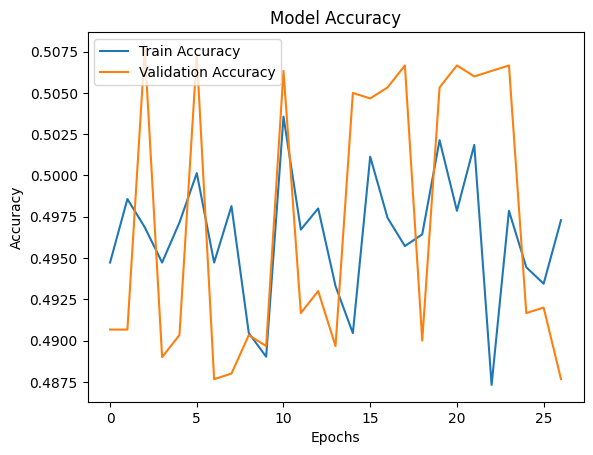

In [24]:
# plotting model accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

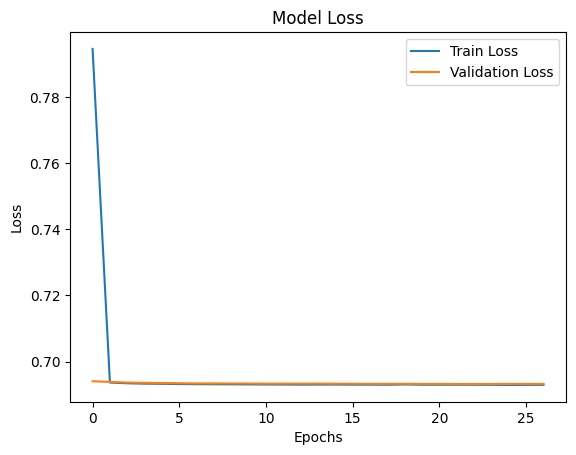

In [25]:
# plotting model loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [26]:
#printing final accuracy 
print(f"Final Loss: {loss:.4f}")
print(f"Final Accuracy: {accuracy * 100:.2f}%")

Final Loss: 0.6932
Final Accuracy: 50.60%


# model number two (learning rate 0.01)

In [27]:
model21 = Sequential([
    Input(shape=(X_train.shape[1],)),  
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid') 
])

In [28]:
from keras.optimizers import SGD

model21.compile(optimizer=SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])


In [29]:
history = model21.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4956 - loss: 1.7222 - val_accuracy: 0.4883 - val_loss: 0.6990
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5007 - loss: 0.6986 - val_accuracy: 0.5030 - val_loss: 0.7070
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4999 - loss: 0.7009 - val_accuracy: 0.4883 - val_loss: 0.7699
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5086 - loss: 0.7007 - val_accuracy: 0.5033 - val_loss: 0.6967
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4960 - loss: 0.6973 - val_accuracy: 0.4867 - val_loss: 0.7033
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4929 - loss: 0.6976 - val_accuracy: 0.4997 - val_loss: 0.6938
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5131 - loss: 0.6944 - val_accuracy: 0.5077 - val_loss: 0.6938
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4981 - loss: 0.6963 - val_accu

In [30]:
# Evaluate the model
loss, accuracy = model21.evaluate(X_test, y_test, verbose=0)

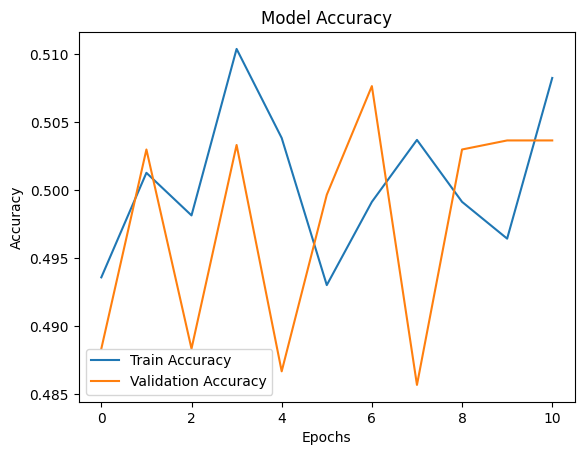

In [31]:
# plotting model accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

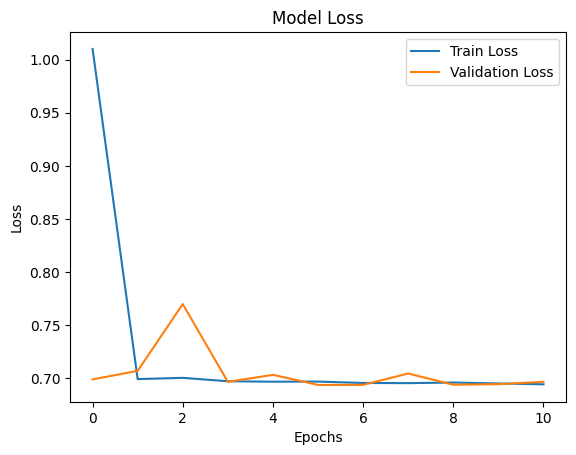

In [32]:
# plotting model loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [33]:
#printing final accuracy 
print(f"Final Loss: {loss:.4f}")
print(f"Final Accuracy: {accuracy * 100:.2f}%")

Final Loss: 0.6938
Final Accuracy: 49.97%


# model number two (learning rate 0.001)

In [34]:
model22 = Sequential([
    Input(shape=(X_train.shape[1],)),  
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid') 
])

In [35]:
from keras.optimizers import SGD

model22.compile(optimizer=SGD(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
history = model22.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5048 - loss: 1.7085 - val_accuracy: 0.5173 - val_loss: 0.6958
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5047 - loss: 0.6952 - val_accuracy: 0.5167 - val_loss: 0.6969
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4946 - loss: 0.6958 - val_accuracy: 0.4977 - val_loss: 0.6969
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5149 - loss: 0.6940 - val_accuracy: 0.5113 - val_loss: 0.6956
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5011 - loss: 0.6960 - val_accuracy: 0.5210 - val_loss: 0.6956
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5045 - loss: 0.6953 - val_accuracy: 0.5150 - val_loss: 0.6957
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5093 - loss: 0.6953 - val_accuracy: 0.5100 - val_loss: 0.6954
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4996 - loss: 0.6958 - val_accu

In [37]:
# Evaluate the model
loss, accuracy = model22.evaluate(X_test, y_test, verbose=0)

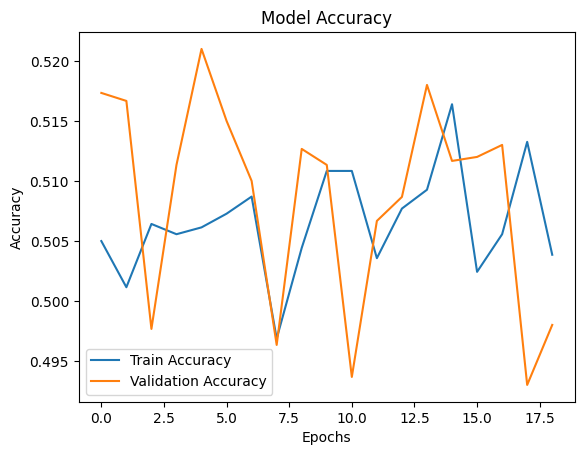

In [38]:
# plotting model accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

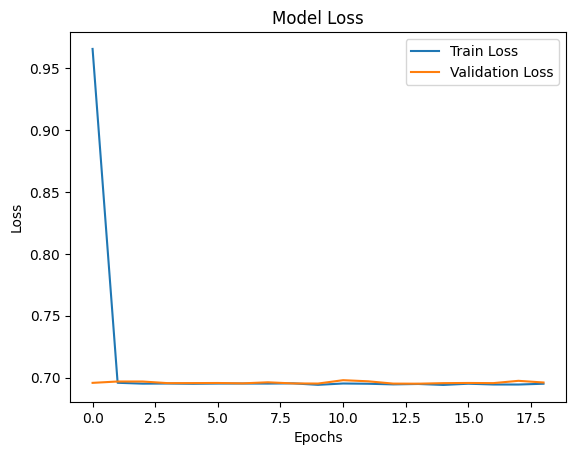

In [39]:
# plotting model loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [40]:
#printing final accuracy 
print(f"Final Loss: {loss:.4f}")
print(f"Final Accuracy: {accuracy * 100:.2f}%")

Final Loss: 0.6951
Final Accuracy: 51.80%


# model number three

In [41]:
model3 = Sequential([
    Input(shape=(X_train.shape[1],)),  
    Dense(128, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid') 
])

In [42]:
# Compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
# Train the model
history = model3.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

Epoch 1/100


220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4891 - loss: 1.4890 - val_accuracy: 0.4803 - val_loss: 0.7010
Epoch 2/100


KeyboardInterrupt: 

In [305]:
# Evaluate the model
loss, accuracy = model3.evaluate(X_test, y_test, verbose=0)

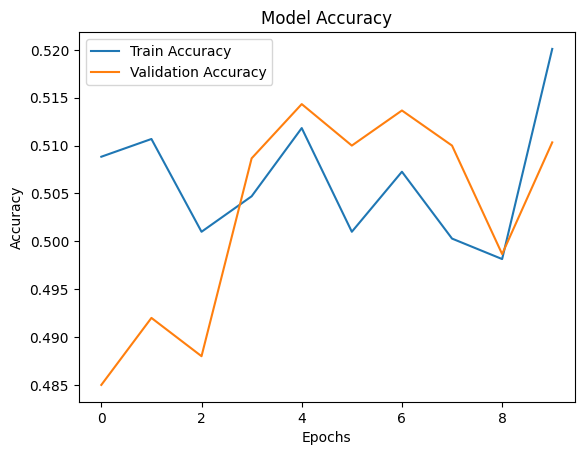

In [306]:
# plotting model accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

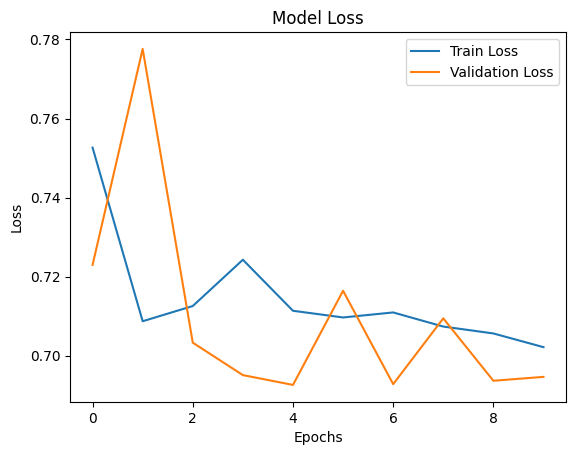

In [307]:
# plotting model loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [308]:
#printing final accuracy 
print(f"Final Loss: {loss:.4f}")
print(f"Final Accuracy: {accuracy * 100:.2f}%")

Final Loss: 0.6926
Final Accuracy: 51.43%


# model number four

In [309]:
model4 = Sequential([
    Input(shape=(X_train.shape[1],)),  
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid') 
])

In [310]:
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [311]:
history = model4.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

Epoch 1/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5068 - loss: 1.6236 - val_accuracy: 0.5150 - val_loss: 0.6935
Epoch 2/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5064 - loss: 0.6971 - val_accuracy: 0.4930 - val_loss: 0.6948
Epoch 3/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4922 - loss: 0.6981 - val_accuracy: 0.5077 - val_loss: 0.7050
Epoch 4/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5067 - loss: 0.6992 - val_accuracy: 0.4860 - val_loss: 0.6947
Epoch 5/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5001 - loss: 0.6989 - val_accuracy: 0.5227 - val_loss: 0.6928
Epoch 6/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5090 - loss: 0.7016 - val_accuracy: 0.4863 - val_loss: 0.7008
Epoch 7/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5197 - loss: 0.6981 - val_accuracy: 0.5090 - val_loss: 0.7059
Epoch 8/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5081 - loss: 0.7089 - val_accu

In [312]:
# Evaluate the model
loss, accuracy = model4.evaluate(X_test, y_test, verbose=0)

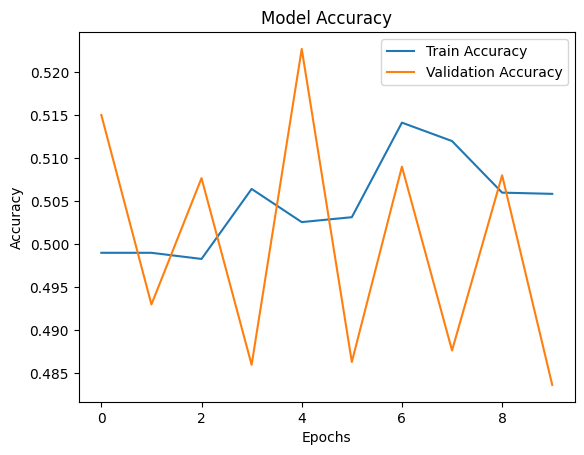

In [313]:
# plotting model accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

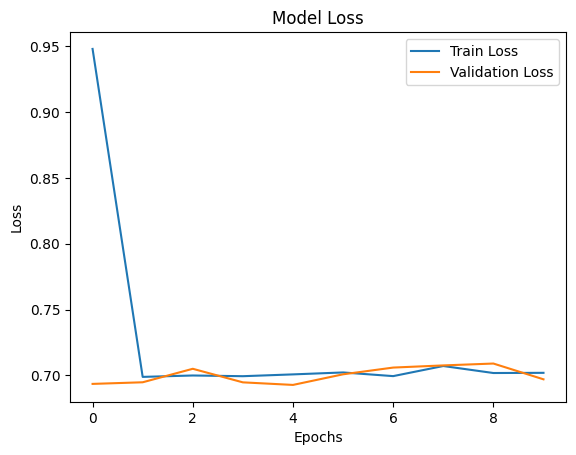

In [314]:
# plotting model loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [315]:
#printing final accuracy 
print(f"Final Loss: {loss:.4f}")
print(f"Final Accuracy: {accuracy * 100:.2f}%")

Final Loss: 0.6928
Final Accuracy: 52.27%


# model number five

In [316]:
model5 = Sequential([
    Input(shape=(X_train.shape[1],)),  
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid') 
])

In [317]:
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [318]:
history = model5.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

Epoch 1/100


110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5118 - loss: 3.4885 - val_accuracy: 0.5090 - val_loss: 0.6961
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5011 - loss: 0.6993 - val_accuracy: 0.4937 - val_loss: 0.6955
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5134 - loss: 0.6948 - val_accuracy: 0.5127 - val_loss: 0.7141
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5153 - loss: 0.6999 - val_accuracy: 0.5093 - val_loss: 0.6932
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5016 - loss: 0.6953 - val_accuracy: 0.4943 - val_loss: 0.7112
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5021 - loss: 0.7060 - val_accuracy: 0.5047 - val_loss: 0.6941
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5016 - loss: 0.6964 - val_accuracy: 0.5007 - val_loss: 0.6940
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5137 - loss: 0.6941 - val_accuracy: 0.4827

In [319]:
# Evaluate the model
loss, accuracy = model5.evaluate(X_test, y_test, verbose=0)

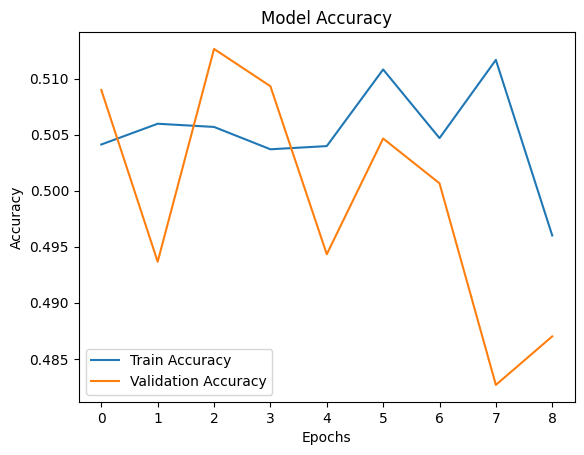

In [320]:
# plotting model accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

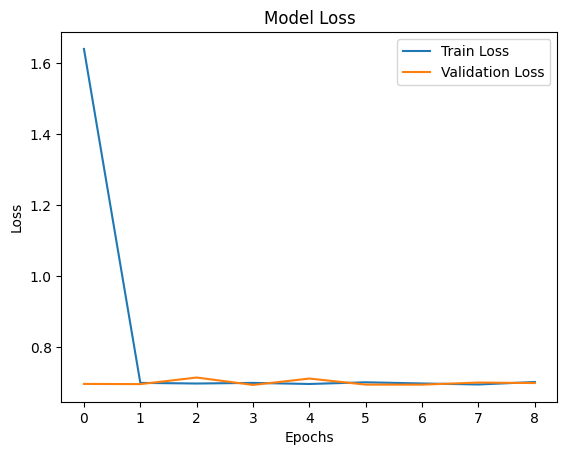

In [321]:
# plotting model loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [322]:
#printing final accuracy 
print(f"Final Loss: {loss:.4f}")
print(f"Final Accuracy: {accuracy * 100:.2f}%")

Final Loss: 0.6932
Final Accuracy: 50.93%


# model number six

In [323]:
model6 = Sequential([
    Input(shape=(X_train.shape[1],)),  
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid') 
])

In [324]:
model6.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

In [325]:
history = model6.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5043 - loss: 1.4574 - val_accuracy: 0.4843 - val_loss: 0.6967
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5036 - loss: 0.7004 - val_accuracy: 0.4877 - val_loss: 0.6939
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5087 - loss: 0.6986 - val_accuracy: 0.4893 - val_loss: 0.6955
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5098 - loss: 0.6955 - val_accuracy: 0.5080 - val_loss: 0.6977
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4938 - loss: 0.6972 - val_accuracy: 0.4873 - val_loss: 0.6945
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5180 - loss: 0.6963 - val_accuracy: 0.5053 - val_loss: 0.6935
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5119 - loss: 0.6946 - val_accuracy: 0.4920 - val_loss: 0.6937
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5015 - loss: 0.6955 - val_accu

In [326]:
# Evaluate the model
loss, accuracy = model6.evaluate(X_test, y_test, verbose=0)

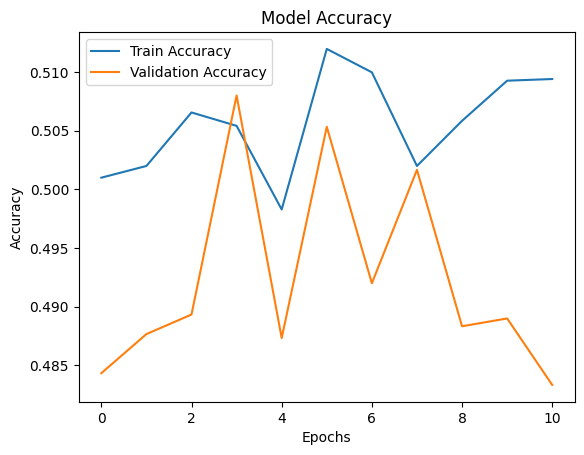

In [327]:
# plotting model accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

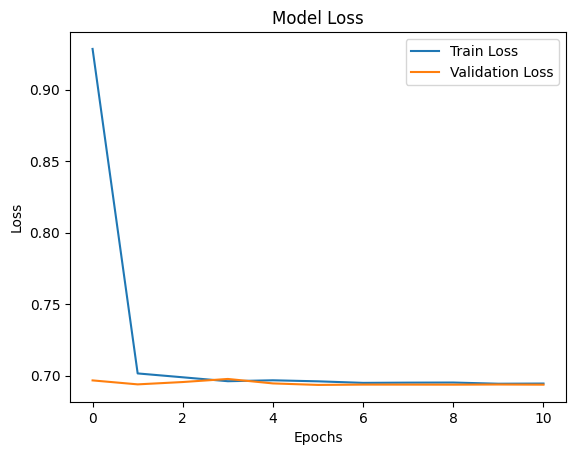

In [328]:
# plotting model loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [329]:
#printing final accuracy 
print(f"Final Loss: {loss:.4f}")
print(f"Final Accuracy: {accuracy * 100:.2f}%")

Final Loss: 0.6935
Final Accuracy: 50.53%


#  model number seven 


In [48]:
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Sequential

model7 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.5),  
    Dense(32, activation='relu'),
    Dropout(0.2),  
    Dense(16, activation='relu'),
    Dropout(0.1),  
    Dense(1, activation='sigmoid')
])


In [49]:
model7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
history = model7.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

Epoch 1/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4967 - loss: 1.0291 - val_accuracy: 0.4947 - val_loss: 0.6950
Epoch 2/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4926 - loss: 0.7212 - val_accuracy: 0.4950 - val_loss: 0.6949
Epoch 3/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5069 - loss: 0.7002 - val_accuracy: 0.5133 - val_loss: 0.6929
Epoch 4/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4918 - loss: 0.7004 - val_accuracy: 0.5080 - val_loss: 0.6928
Epoch 5/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4960 - loss: 0.6980 - val_accuracy: 0.4950 - val_loss: 0.6933
Epoch 6/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5026 - loss: 0.6966 - val_accuracy: 0.5080 - val_loss: 0.6931
Epoch 7/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4892 - loss: 0.6958 - val_accuracy: 0.5080 - val_loss: 0.6930
Epoch 8/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4970 - loss: 0.6950 - val_accu

In [51]:
# Evaluate the model
loss, accuracy = model7.evaluate(X_test, y_test, verbose=0)

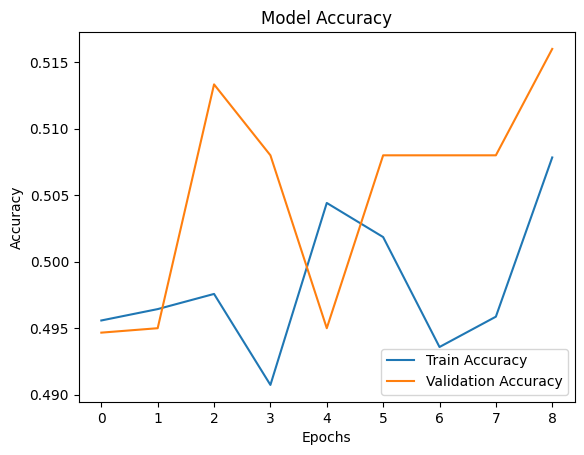

In [52]:
# plotting model accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

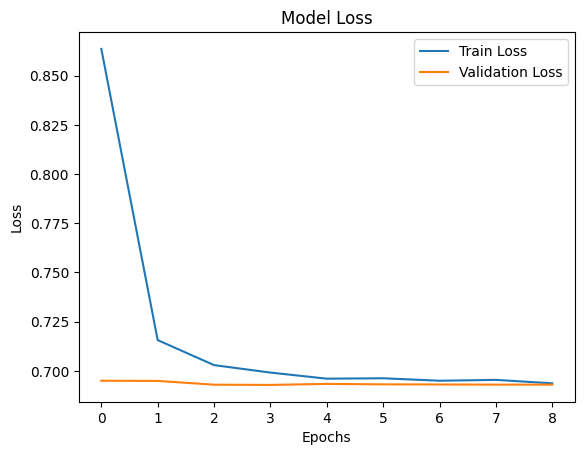

In [53]:
# plotting model loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [54]:
#printing final accuracy 
print(f"Final Loss: {loss:.4f}")
print(f"Final Accuracy: {accuracy * 100:.2f}%")

Final Loss: 0.6928
Final Accuracy: 50.80%
